In [1]:
import glob, os, cv2, tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

+ leaf_weight: 1일 후의 잎 면적(중량)

In [2]:
tr_dirs = glob.glob("data/train/*")

In [3]:
tr_df = pd.concat([pd.read_csv(f"{i}/label.csv") for i in tr_dirs], ignore_index=True)
tr_df["path"] = [i.split("_")[0] for i in tr_df["img_name"].values]
tr_df["file_name"] = [i.split(".")[0] for i in tr_df["img_name"].values]
tr_df = tr_df[["path","file_name","leaf_weight"]]

data_path = "data"

+ 1일 후의 잎 면적을 딥러닝으로 추정
+ 딥러닝 모델의 변수를 활용하여 머신러닝으로 추정

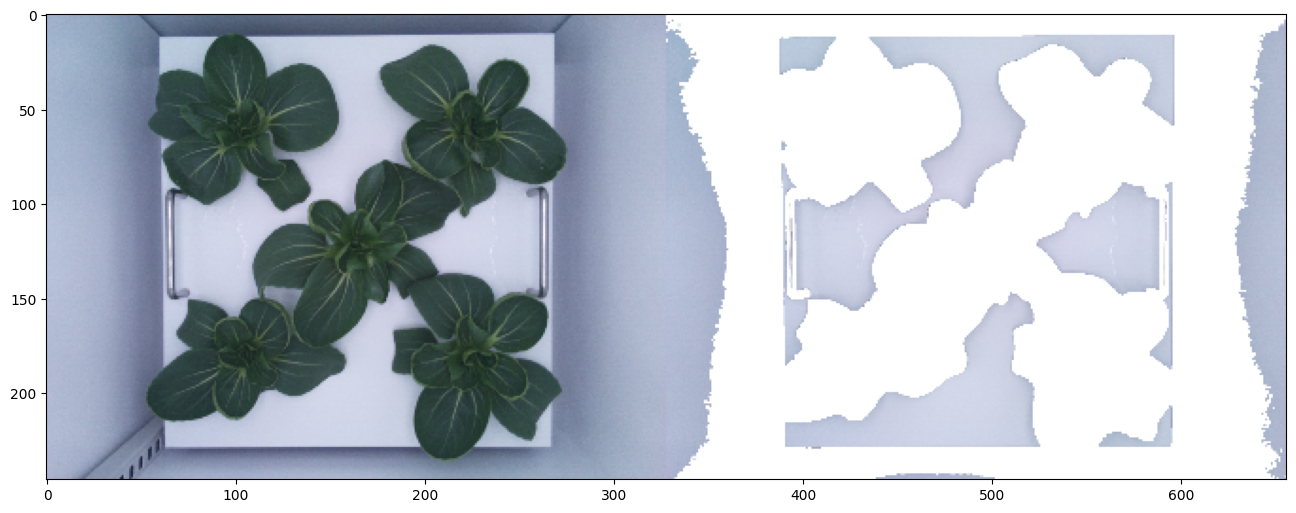

In [13]:
value = tr_df.values[0]
img_path = f"{data_path}/train/{value[0]}/image/{value[1]}.png"
if not os.path.exists(img_path):
    img_path = img_path.replace("png","jpg")
img = cv2.imread(img_path)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
# H의 range 는 0~ 179
# 청록색(80~110, 100~255, 80~200)
lower = np.array([0, 0, 200], dtype=np.uint8)
upper = np.array([255, 255, 255], dtype=np.uint8)

mask = cv2.inRange(hsv, lower, upper)

kernel = np.ones((10,10), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)   # 작은 노이즈 제거
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  # 구멍 메우기

result = cv2.bitwise_and(img, img, mask=mask)

result[result==0]=255
result = np.concatenate([img, result], axis=1)

W, H = result.shape[:2]
n = 10
result = cv2.resize(result, (H//n, W//n))
plt.figure(figsize=(16, 12))  # 가로 10, 세로 8로 크기 지정
plt.imshow(result[...,::-1])

In [236]:
save_dir = "export"
os.makedirs(save_dir, exist_ok=True)
for value in tqdm.tqdm(tr_df.values):
    img_path = f"{data_path}/train/{value[0]}/image/{value[1]}.png"
    if not os.path.exists(img_path):
        img_path = img_path.replace("png","jpg")
    img = cv2.imread(img_path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # H의 range 는 0~ 179
    
    # 추가할 연두 범위
    lower = np.array([25, 0, 0], dtype=np.uint8)  # H, S, V
    upper = np.array([110, 160, 200], dtype=np.uint8)
    mask = cv2.inRange(hsv, lower, upper)
        
    # 이미지 적용
    result = cv2.bitwise_and(img, img, mask=mask)
    result[result==0]=255
    result = np.concatenate([img, result], axis=1)

    W, H = result.shape[:2]
    n = 5
    result = cv2.resize(result, (H//n, W//n))
    # plt.imshow(result)
    file_name = os.path.basename(img_path)
    cv2.imwrite(f"{save_dir}/{file_name}", result)
    # break
# plt.figure(figsize=(16, 12))  # 가로 10, 세로 8로 크기 지정
# plt.imshow(result[...,::-1])

100%|██████████| 1592/1592 [04:57<00:00,  5.36it/s]


In [17]:
save_dir1 = "export2/train_view"
os.makedirs(save_dir1, exist_ok=True)
save_dir2 = "export2/train"
os.makedirs(save_dir2, exist_ok=True)
for value in tqdm.tqdm(tr_df.values):
    img_path = f"{data_path}/train/{value[0]}/image/{value[1]}.png"
    if not os.path.exists(img_path):
        img_path = img_path.replace("png","jpg")
    img = cv2.imread(img_path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    lower = np.array([0, 0, 20], dtype=np.uint8)
    upper = np.array([180, 70, 100], dtype=np.uint8)
    mask_background = cv2.inRange(hsv, lower, upper)
    
    kernel_size = 100
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    mask_background_closed = cv2.morphologyEx(mask_background, cv2.MORPH_CLOSE, kernel)
    
    # result = cv2.bitwise_and(img, img, mask=mask_background_closed)
    # result[result==0]=255
    # result = np.concatenate([img, result], axis=1)

    lower = np.array([30, 0, 0], dtype=np.uint8)  # H, S, V
    upper = np.array([100, 255, 200], dtype=np.uint8)
    mask_target = cv2.inRange(hsv, lower, upper)


    # 두 마스크 합치기
    mask_total = cv2.bitwise_and(mask_target, mask_background_closed)
    
    # 이미지 적용
    result = cv2.bitwise_and(img, img, mask=mask_target)
    result[(result[:,:,0] == 0) & (result[:,:,1] == 0) & (result[:,:,2] == 0)]=255
    result_concat = np.concatenate([img, result], axis=1)

    W, H = result.shape[:2]
    n = 5
    result_concat = cv2.resize(result_concat, (H//n, W//n))
    # plt.imshow(result)
    file_name = os.path.basename(img_path)
    cv2.imwrite(f"{save_dir1}/{file_name}", result_concat)
    result = cv2.resize(result , (H//8, W//8))
    cv2.imwrite(f"{save_dir2}/{file_name}", result)
    # break
# plt.figure(figsize=(16, 12))  # 가로 10, 세로 8로 크기 지정
# plt.imshow(result[...,::-1])

100%|██████████| 1592/1592 [07:20<00:00,  3.61it/s]


In [412]:
import shutil
te_files = glob.glob("data/test/image/*")

export_path = "data/test_v2"
for te_file in tqdm.tqdm(te_files):
    saved_dir = te_file.split("/")[-1].split(".")[0]
    img_saved_dir = f"{export_path}/{saved_dir}/image"
    file_name = os.path.basename(te_file)
    os.makedirs(img_saved_dir, exist_ok=True)
    shutil.copy(te_file, f"{img_saved_dir}/{file_name}")
    meta_file = te_file.replace("image","meta").replace("png","csv").replace("jpg","csv")
    meta_saved_dir = f"{export_path}/{saved_dir}/meta"
    file_name = os.path.basename(meta_file)
    os.makedirs(meta_saved_dir, exist_ok=True)
    shutil.copy(meta_file, f"{meta_saved_dir}/{file_name}")

100%|██████████| 460/460 [00:02<00:00, 227.15it/s]


In [15]:
te_path=list(set(os.listdir("data/test_v2")) - set([".ipynb_checkpoints"]))
te_df = pd.DataFrame({"path":te_path,"file_name":te_path})

In [18]:
save_dir1 = "export2/test_view"
os.makedirs(save_dir1, exist_ok=True)
save_dir2 = "export2/test"
os.makedirs(save_dir2, exist_ok=True)
for value in tqdm.tqdm(te_df.values):
    img_path = f"{data_path}/test_v2/{value[0]}/image/{value[1]}.png"
    if not os.path.exists(img_path):
        img_path = img_path.replace("png","jpg")
    img = cv2.imread(img_path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    lower = np.array([0, 0, 20], dtype=np.uint8)
    upper = np.array([180, 70, 100], dtype=np.uint8)
    mask_background = cv2.inRange(hsv, lower, upper)
    
    kernel_size = 100
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    mask_background_closed = cv2.morphologyEx(mask_background, cv2.MORPH_CLOSE, kernel)
    
    lower = np.array([30, 0, 0], dtype=np.uint8)  # H, S, V
    upper = np.array([100, 255, 200], dtype=np.uint8)
    mask_target = cv2.inRange(hsv, lower, upper)

    # 두 마스크 합치기
    mask_total = cv2.bitwise_and(mask_target, mask_background_closed)
    
    # 이미지 적용
    result = cv2.bitwise_and(img, img, mask=mask_target)
    result[(result[:,:,0] == 0) & (result[:,:,1] == 0) & (result[:,:,2] == 0)]=255
    result_concat = np.concatenate([img, result], axis=1)

    W, H = result.shape[:2]
    n = 5
    result_concat = cv2.resize(result_concat, (H//n, W//n))
    result = cv2.resize(result , (H//8, W//8))
    # plt.imshow(result)
    file_name = os.path.basename(img_path)
    cv2.imwrite(f"{save_dir1}/{file_name}", result_concat)
    cv2.imwrite(f"{save_dir2}/{file_name}", result)


100%|██████████| 460/460 [02:02<00:00,  3.77it/s]


# zip -r export2.zip export2/

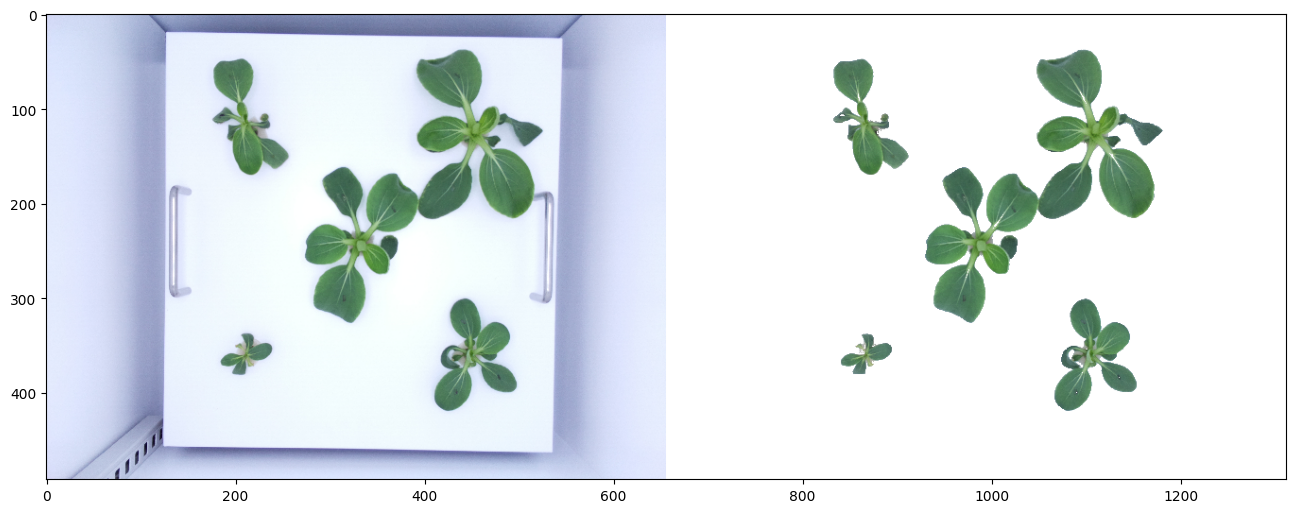

In [330]:
img_path = f"{data_path}/train/CASE57/image/CASE57_17.png"
if not os.path.exists(img_path):
    img_path = img_path.replace("png","jpg")
img = cv2.imread(img_path)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

lower = np.array([0, 0, 20], dtype=np.uint8)
upper = np.array([180, 70, 100], dtype=np.uint8)
mask_background = cv2.inRange(hsv, lower, upper)

kernel_size = 100
kernel = np.ones((kernel_size, kernel_size), np.uint8)
mask_background_closed = cv2.morphologyEx(mask_background, cv2.MORPH_CLOSE, kernel)

# result = cv2.bitwise_and(img, img, mask=mask_background_closed)
# result[result==0]=255
# result = np.concatenate([img, result], axis=1)

lower = np.array([30, 0, 0], dtype=np.uint8)  # H, S, V
upper = np.array([100, 255, 200], dtype=np.uint8)
mask_target = cv2.inRange(hsv, lower, upper)


# 두 마스크 합치기
mask_total = cv2.bitwise_and(mask_target, mask_background_closed)

# 이미지 적용
result = cv2.bitwise_and(img, img, mask=mask_target)
result[result==0]=255
result = np.concatenate([img, result], axis=1)

W, H = result.shape[:2]
n = 5
result = cv2.resize(result, (H//n, W//n))

plt.figure(figsize=(16, 12))  # 가로 10, 세로 8로 크기 지정
plt.imshow(result[...,::-1])

In [318]:
img